In [12]:
# Main Setup

# imports
import snntorch as snn
from snntorch import spikeplot as splt
from snntorch import spikegen

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

import matplotlib.pyplot as plt
import numpy as np
import itertools
import gc

# dataloader arguments
batch_size = 128
data_path='/media/johnm/samsung/tmp/data/mnist'

dtype = torch.float
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")
print(device)

# Define a transform
transform = transforms.Compose([
            transforms.Resize((28, 28)),
            transforms.Grayscale(),
            transforms.ToTensor(),
            transforms.Normalize((0,), (1,))])

mnist_train = datasets.MNIST(data_path, train=True, download=True, transform=transform)
mnist_test = datasets.MNIST(data_path, train=False, download=True, transform=transform)

# Create DataLoaders
train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(mnist_test, batch_size=batch_size, shuffle=True, drop_last=True)

# Network Architecture
num_inputs = 28*28
num_hidden = 1000
num_outputs = 10

# Temporal Dynamics
num_steps = 25
beta = 0.70

V1 = 0.5 # shared recurrent connection
V2 = torch.rand(num_outputs) # unshared recurrent connections

# Define Network
class Net(nn.Module):
    def __init__(self):
        super().__init__()

        # initialize layers
        self.fc1 = nn.Linear(num_inputs, num_hidden)

        # Default RLeaky Layer where recurrent connections
        # are initialized using PyTorch defaults in nn.Linear.
        self.lif1 = snn.RLeaky(beta=beta,
                    linear_features=num_hidden)

        self.fc2 = nn.Linear(num_hidden, num_outputs)

        # each neuron has a single connection back to itself
        # where the output spike is scaled by V.
        # For `all_to_all = False`, V can be shared between
        # neurons (e.g., V1) or unique / unshared between
        # neurons (e.g., V2).
        # V is learnable by default.
        self.lif2 = snn.RLeaky(beta=beta, all_to_all=False, V=V1)

    def forward(self, x):
        # Initialize hidden states at t=0
        spk1, mem1 = self.lif1.init_rleaky()
        spk2, mem2 = self.lif2.init_rleaky()

        # Record output layer spikes and membrane
        spk2_rec = []
        mem2_rec = []

        # time-loop
        for step in range(num_steps):
            cur1 = self.fc1(x)
            spk1, mem1 = self.lif1(cur1, spk1, mem1)
            cur2 = self.fc2(spk1)
            spk2, mem2 = self.lif2(cur2, spk2, mem2)

            spk2_rec.append(spk2)
            mem2_rec.append(mem2)

        # convert lists to tensors
        spk2_rec = torch.stack(spk2_rec)
        mem2_rec = torch.stack(mem2_rec)

        return spk2_rec, mem2_rec

# Load the network onto CUDA if available
net = Net().to(device)

# pass data into the network, sum the spikes over time
# and compare the neuron with the highest number of spikes
# with the target

def print_batch_accuracy(data, targets, train=False):
    output, _ = net(data.view(batch_size, -1))
    _, idx = output.sum(dim=0).max(1)
    acc = np.mean((targets == idx).detach().cpu().numpy())

    if train:
        print(f"Train set accuracy for a single minibatch: {acc*100:.2f}%")
    else:
        print(f"Test set accuracy for a single minibatch: {acc*100:.2f}%")

def train_printer(
    data, targets, epoch,
    counter, iter_counter,
        loss_hist, test_loss_hist, test_data, test_targets):
    print(f"Epoch {epoch}, Iteration {iter_counter}")
    print(f"Train Set Loss: {loss_hist[counter]:.2f}")
    print(f"Test Set Loss: {test_loss_hist[counter]:.2f}")
    print_batch_accuracy(data, targets, train=True)
    print_batch_accuracy(test_data, test_targets, train=False)
    print("\n")

loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=5e-4, betas=(0.9, 0.999))

data, targets = next(iter(train_loader))
data = data.to(device)
targets = targets.to(device)

spk_rec, mem_rec = net(data.view(batch_size, -1))
# print(mem_rec.size())

# initialize the total loss value
loss_val = torch.zeros((1), dtype=dtype, device=device)

# sum loss at every step
for step in range(num_steps):
  loss_val += loss(mem_rec[step], targets)

# print(f"Training loss: {loss_val.item():.3f}")
# print_batch_accuracy(data, targets, train=True)

# clear previously stored gradients
optimizer.zero_grad()

# calculate the gradients
loss_val.backward()

# weight update
optimizer.step()

# calculate new network outputs using the same data
spk_rec, mem_rec = net(data.view(batch_size, -1))

# initialize the total loss value
loss_val = torch.zeros((1), dtype=dtype, device=device)

# sum loss at every step
for step in range(num_steps):
  loss_val += loss(mem_rec[step], targets)

# print(f"Training loss: {loss_val.item():.3f}")
# print_batch_accuracy(data, targets, train=True)

cuda


In [13]:
# Training Loop 
num_epochs = 1
loss_hist = []
test_loss_hist = []
counter = 0

# Outer training loop
for epoch in range(num_epochs):
    iter_counter = 0
    train_batch = iter(train_loader)

    # Minibatch training loop
    for data, targets in train_batch:
        data = data.to(device)
        targets = targets.to(device)

        # forward pass
        net.train()
        spk_rec, mem_rec = net(data.view(batch_size, -1))

        # initialize the loss & sum over time
        loss_val = torch.zeros((1), dtype=dtype, device=device)
        for step in range(num_steps):
            loss_val += loss(mem_rec[step], targets)

        # Gradient calculation + weight update
        optimizer.zero_grad()
        loss_val.backward()
        optimizer.step()

        # Store loss history for future plotting
        loss_hist.append(loss_val.item())

        # Test set
        with torch.no_grad():
            net.eval()
            test_data, test_targets = next(iter(test_loader))
            test_data = test_data.to(device)
            test_targets = test_targets.to(device)

            # Test set forward pass
            test_spk, test_mem = net(test_data.view(batch_size, -1))

            # Test set loss
            test_loss = torch.zeros((1), dtype=dtype, device=device)
            for step in range(num_steps):
                test_loss += loss(test_mem[step], test_targets)
            test_loss_hist.append(test_loss.item())

            # Print train/test loss/accuracy
            if counter % 50 == 0:
                train_printer(
                    data, targets, epoch,
                    counter, iter_counter,
                    loss_hist, test_loss_hist,
                    test_data, test_targets)
            counter += 1
            iter_counter +=1

Epoch 0, Iteration 0
Train Set Loss: 56.21
Test Set Loss: 52.80
Train set accuracy for a single minibatch: 16.41%
Test set accuracy for a single minibatch: 14.06%


Epoch 0, Iteration 50
Train Set Loss: 15.18
Test Set Loss: 15.76
Train set accuracy for a single minibatch: 91.41%
Test set accuracy for a single minibatch: 88.28%


Epoch 0, Iteration 100
Train Set Loss: 12.86
Test Set Loss: 9.10
Train set accuracy for a single minibatch: 92.97%
Test set accuracy for a single minibatch: 91.41%


Epoch 0, Iteration 150
Train Set Loss: 7.27
Test Set Loss: 8.40
Train set accuracy for a single minibatch: 98.44%
Test set accuracy for a single minibatch: 93.75%


Epoch 0, Iteration 200
Train Set Loss: 11.29
Test Set Loss: 6.46
Train set accuracy for a single minibatch: 89.84%
Test set accuracy for a single minibatch: 98.44%


Epoch 0, Iteration 250
Train Set Loss: 9.40
Test Set Loss: 7.21
Train set accuracy for a single minibatch: 92.19%
Test set accuracy for a single minibatch: 97.66%


Epoch 0

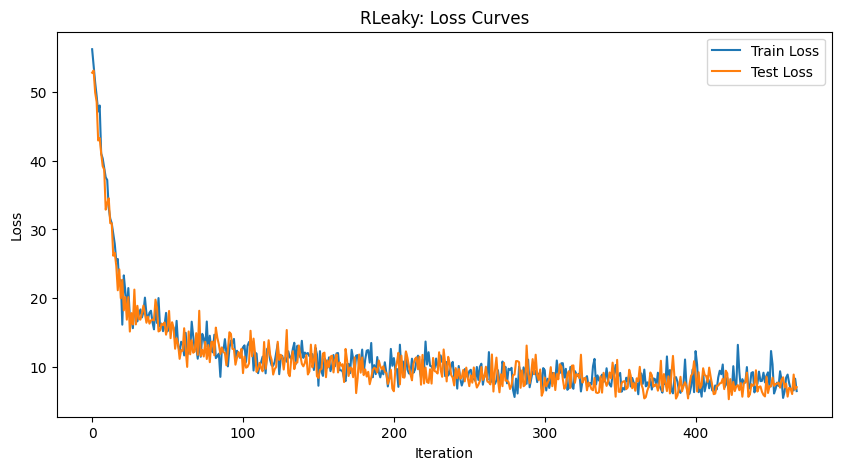

In [14]:
# Plot Loss
fig = plt.figure(facecolor="w", figsize=(10, 5))
plt.plot(loss_hist)
plt.plot(test_loss_hist)
plt.title("RLeaky: Loss Curves")
plt.legend(["Train Loss", "Test Loss"])
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

In [15]:
# Initial Evaluation

# Test Accuracy

total = 0
correct = 0

# drop_last switched to False to keep all samples
test_loader = DataLoader(mnist_test, batch_size=batch_size, shuffle=True, drop_last=False)

with torch.no_grad():
  net.eval()
  for data, targets in test_loader:
    data = data.to(device)
    targets = targets.to(device)
    
    # forward pass
    test_spk, _ = net(data.view(data.size(0), -1))

    # calculate total accuracy
    _, predicted = test_spk.sum(dim=0).max(1)
    total += targets.size(0)
    correct += (predicted == targets).sum().item()

print(f"Total correctly classified test set images: {correct}/{total}")
print(f"Test Set Accuracy: {100 * correct / total:.2f}%")

Total correctly classified test set images: 9421/10000
Test Set Accuracy: 94.21%


In [16]:
# Save Ref Network
torch.save(net.state_dict(), 'ref_snn_rleaky.pth')

In [17]:
# Testing Setup

test_net = Net()

test_net.load_state_dict(torch.load('ref_snn_rleaky.pth'))

test_net.to(device)


print("Testing Loaded Network")


def acc_test(net, mnist_test, batch_size):
    # Test Accuracy

    total = 0
    correct = 0

    # drop_last switched to False to keep all samples
    test_loader = DataLoader(mnist_test, batch_size=batch_size, shuffle=True, drop_last=False)

    with torch.no_grad():
        net.eval()
        for data, targets in test_loader:
            data = data.to(device)
            targets = targets.to(device)
            
            # forward pass
            test_spk, _ = net(data.view(data.size(0), -1))

            # calculate total accuracy
            _, predicted = test_spk.sum(dim=0).max(1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()

    # print(f"Total correctly classified test set images: {correct}/{total}")
    # print(f"Test Set Accuracy: {100 * correct / total:.2f}%")
    return 100 * correct / total

def mod_fc1(net, neuron_index): # neuron_index 0 to 999
    # Print the initial weights
    # print("Initial weights:", net.fc1.weight)

    # Access the parameters
    parameters = net.parameters()

    # Assuming you want to modify the weights of the first neuron in the linear layer
    # neuron_index = 1    # 0 to 999
    for param in parameters:
        if param is net.fc1.weight:
            # Modify the weights of the first neuron
            new_weights = torch.randn(param.size(1))  # Example: Initialize new weights randomly
            param.data[neuron_index] = new_weights

    # Print the modified weights
    # print("Modified weights:", net.fc1.weight)
    # print("Size of Weights: ", net.fc1.weight.size())
    return net

def mod_fc2(net, neuron_index): # neuron_index 0 to 9
    # Print the initial weights
    # print("Initial weights:", net.fc2.weight)

    # Access the parameters
    parameters = net.parameters()

    # Assuming you want to modify the weights of the first neuron in the linear layer
    # neuron_index = 4     # 0 to 9
    for param in parameters:
        if param is net.fc2.weight:
            # Modify the weights of the first neuron
            new_weights = torch.randn(param.size(1))  # Example: Initialize new weights randomly
            param.data[neuron_index] = new_weights

    # Print the modified weights
    # print("Modified weights:", net.fc2.weight)
    # print("Size of Weights: ", net.fc2.weight.size())
    return net

Testing Loaded Network


In [18]:
# Output Layer Corruption

fc2_acc_loss_rec = []
with torch.no_grad():
    test_net = Net()
    test_net.load_state_dict(torch.load('ref_snn_rleaky.pth'))
    test_net.to(device)

acc_ref = acc_test(test_net, mnist_test, batch_size)
print(f"Base Accuracy: {(acc_ref):.2f}%")
for x in range(0,10):
    with torch.no_grad():
        test_net = Net()
        test_net.load_state_dict(torch.load('ref_snn_rleaky.pth'))
        test_net.to(device)
        acc = acc_test(mod_fc2(test_net, x), mnist_test, batch_size)
        print(f"Accuracy loss of Output Layer Parameter Corruption({x}): {(acc_ref-acc):.2f}%")
        fc2_acc_loss_rec.append(acc_ref-acc)
    del test_net
    torch.cuda.empty_cache()

# fc2_acc_loss_rec = torch.stack(fc2_acc_loss_rec, dim = 0)
print(fc2_acc_loss_rec)

Base Accuracy: 94.21%
Accuracy loss of Output Layer Parameter Corruption(0): 23.44%
Accuracy loss of Output Layer Parameter Corruption(1): 28.51%
Accuracy loss of Output Layer Parameter Corruption(2): 15.09%
Accuracy loss of Output Layer Parameter Corruption(3): 34.93%
Accuracy loss of Output Layer Parameter Corruption(4): 23.79%
Accuracy loss of Output Layer Parameter Corruption(5): 21.77%
Accuracy loss of Output Layer Parameter Corruption(6): 15.55%
Accuracy loss of Output Layer Parameter Corruption(7): 15.92%
Accuracy loss of Output Layer Parameter Corruption(8): 28.16%
Accuracy loss of Output Layer Parameter Corruption(9): 13.82%
[23.439999999999998, 28.50999999999999, 15.08999999999999, 34.92999999999999, 23.789999999999992, 21.769999999999996, 15.549999999999997, 15.919999999999987, 28.159999999999997, 13.819999999999993]


In [19]:
torch.cuda.mem_get_info()

(31473008640, 32195477504)

In [20]:
# Hidden Layer Corruption

fc1_acc_loss_rec = []

with torch.no_grad():
    test_net = Net()
    test_net.load_state_dict(torch.load('ref_snn_rleaky.pth'))
    test_net.to(device)


acc_ref = acc_test(test_net, mnist_test, batch_size)
print(f"Base Accuracy: {(acc_ref):.2f}%")
for x in range(0,1000):
    with torch.no_grad():
        test_net = Net()
        test_net.load_state_dict(torch.load('ref_snn_rleaky.pth'))
        test_net.to(device)
        acc = acc_test(mod_fc1(test_net, x), mnist_test, batch_size)
        print(f"Accuracy loss of Hidden Layer Parameter Corruption({x}): {(acc_ref-acc):.2f}%")
        fc1_acc_loss_rec.append(acc_ref-acc)
    del test_net
    torch.cuda.empty_cache()

# fc1_acc_loss_rec = torch.stack(fc1_acc_loss_rec, dim = 0)

Base Accuracy: 94.21%
Accuracy loss of Hidden Layer Parameter Corruption(0): 0.15%
Accuracy loss of Hidden Layer Parameter Corruption(1): 0.00%
Accuracy loss of Hidden Layer Parameter Corruption(2): -0.03%
Accuracy loss of Hidden Layer Parameter Corruption(3): 0.09%
Accuracy loss of Hidden Layer Parameter Corruption(4): -0.05%
Accuracy loss of Hidden Layer Parameter Corruption(5): -0.15%
Accuracy loss of Hidden Layer Parameter Corruption(6): 0.02%
Accuracy loss of Hidden Layer Parameter Corruption(7): 0.09%
Accuracy loss of Hidden Layer Parameter Corruption(8): 0.05%
Accuracy loss of Hidden Layer Parameter Corruption(9): 0.01%
Accuracy loss of Hidden Layer Parameter Corruption(10): -0.02%
Accuracy loss of Hidden Layer Parameter Corruption(11): 0.04%
Accuracy loss of Hidden Layer Parameter Corruption(12): 0.11%
Accuracy loss of Hidden Layer Parameter Corruption(13): -0.01%
Accuracy loss of Hidden Layer Parameter Corruption(14): 0.07%
Accuracy loss of Hidden Layer Parameter Corruption(15

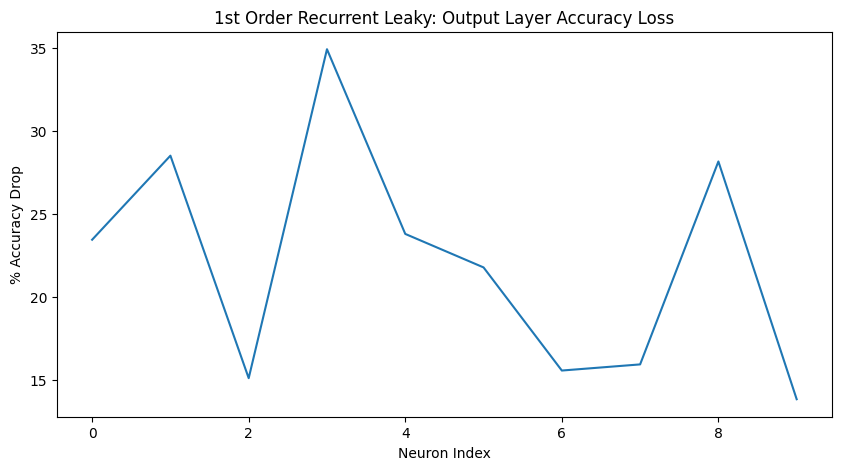

In [21]:
# Plot Accuracy Dop
fig = plt.figure(facecolor="w", figsize=(10, 5))
plt.plot(fc2_acc_loss_rec)
# plt.plot(test_loss_hist)
plt.title("1st Order Recurrent Leaky: Output Layer Accuracy Loss")
#plt.legend(["Train Loss", "Test Loss"])
plt.xlabel("Neuron Index")
plt.ylabel("% Accuracy Drop")
plt.show()

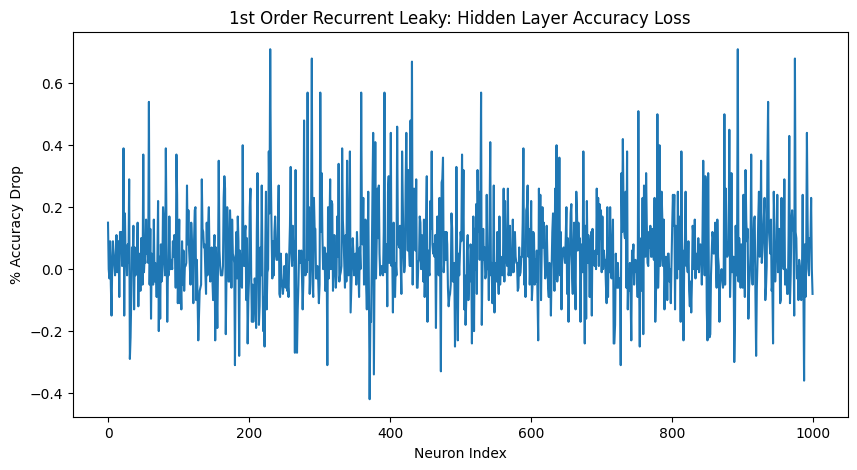

In [22]:
# Plot Accuracy Dop
fig = plt.figure(facecolor="w", figsize=(10, 5))
plt.plot(fc1_acc_loss_rec)
# plt.plot(test_loss_hist)
plt.title("1st Order Recurrent Leaky: Hidden Layer Accuracy Loss")
#plt.legend(["Train Loss", "Test Loss"])
plt.xlabel("Neuron Index")
plt.ylabel("% Accuracy Drop")
plt.show()

In [23]:
# Multi-trial Output Layer Corruption

print("Starting Output Layer Trial 2")
fc2_acc_loss_rec_2 = []

with torch.no_grad():
    test_net = Net()
    test_net.load_state_dict(torch.load('ref_snn_rleaky.pth'))
    test_net.to(device)

acc_ref = acc_test(test_net, mnist_test, batch_size)
# print(f"Base Accuracy: {(acc_ref):.2f}%")
for x in range(0,10):
    with torch.no_grad():
        test_net = Net()
        test_net.load_state_dict(torch.load('ref_snn_rleaky.pth'))
        test_net.to(device)
        acc = acc_test(mod_fc2(test_net, x), mnist_test, batch_size)
        # print(f"Accuracy loss of Output Layer Parameter Corruption({x}): {(acc_ref-acc):.2f}%")
        fc2_acc_loss_rec_2.append(acc_ref-acc)
    del test_net
    torch.cuda.empty_cache()


print("Starting Output Layer Trial 3")
fc2_acc_loss_rec_3 = []

with torch.no_grad():
    test_net = Net()
    test_net.load_state_dict(torch.load('ref_snn_rleaky.pth'))
    test_net.to(device)

acc_ref = acc_test(test_net, mnist_test, batch_size)
# print(f"Base Accuracy: {(acc_ref):.2f}%")
for x in range(0,10):
    with torch.no_grad():
        test_net = Net()
        test_net.load_state_dict(torch.load('ref_snn_rleaky.pth'))
        test_net.to(device)
        acc = acc_test(mod_fc2(test_net, x), mnist_test, batch_size)
        # print(f"Accuracy loss of Output Layer Parameter Corruption({x}): {(acc_ref-acc):.2f}%")
        fc2_acc_loss_rec_3.append(acc_ref-acc)
    del test_net
    torch.cuda.empty_cache()

print("Starting Output Layer Trial 4")
fc2_acc_loss_rec_4 = []

with torch.no_grad():
    test_net = Net()
    test_net.load_state_dict(torch.load('ref_snn_rleaky.pth'))
    test_net.to(device)

acc_ref = acc_test(test_net, mnist_test, batch_size)
# print(f"Base Accuracy: {(acc_ref):.2f}%")
for x in range(0,10):
    with torch.no_grad():
        test_net = Net()
        test_net.load_state_dict(torch.load('ref_snn_rleaky.pth'))
        test_net.to(device)
        acc = acc_test(mod_fc2(test_net, x), mnist_test, batch_size)
        # print(f"Accuracy loss of Output Layer Parameter Corruption({x}): {(acc_ref-acc):.2f}%")
        fc2_acc_loss_rec_4.append(acc_ref-acc)
    del test_net
    torch.cuda.empty_cache()


print("Starting Output Layer Trial 5")
fc2_acc_loss_rec_5 = []

with torch.no_grad():
    test_net = Net()
    test_net.load_state_dict(torch.load('ref_snn_rleaky.pth'))
    test_net.to(device)

acc_ref = acc_test(test_net, mnist_test, batch_size)
# print(f"Base Accuracy: {(acc_ref):.2f}%")
for x in range(0,10):
    with torch.no_grad():
        test_net = Net()
        test_net.load_state_dict(torch.load('ref_snn_rleaky.pth'))
        test_net.to(device)
        acc = acc_test(mod_fc2(test_net, x), mnist_test, batch_size)
        # print(f"Accuracy loss of Output Layer Parameter Corruption({x}): {(acc_ref-acc):.2f}%")
        fc2_acc_loss_rec_5.append(acc_ref-acc)
    del test_net
    torch.cuda.empty_cache()


print("Starting Output Layer Trial 6")
fc2_acc_loss_rec_6 = []

with torch.no_grad():
    test_net = Net()
    test_net.load_state_dict(torch.load('ref_snn_rleaky.pth'))
    test_net.to(device)

acc_ref = acc_test(test_net, mnist_test, batch_size)
# print(f"Base Accuracy: {(acc_ref):.2f}%")
for x in range(0,10):
    with torch.no_grad():
        test_net = Net()
        test_net.load_state_dict(torch.load('ref_snn_rleaky.pth'))
        test_net.to(device)
        acc = acc_test(mod_fc2(test_net, x), mnist_test, batch_size)
        # print(f"Accuracy loss of Output Layer Parameter Corruption({x}): {(acc_ref-acc):.2f}%")
        fc2_acc_loss_rec_6.append(acc_ref-acc)
    del test_net
    torch.cuda.empty_cache()






Starting Output Layer Trial 2
Starting Output Layer Trial 3
Starting Output Layer Trial 4
Starting Output Layer Trial 5
Starting Output Layer Trial 6


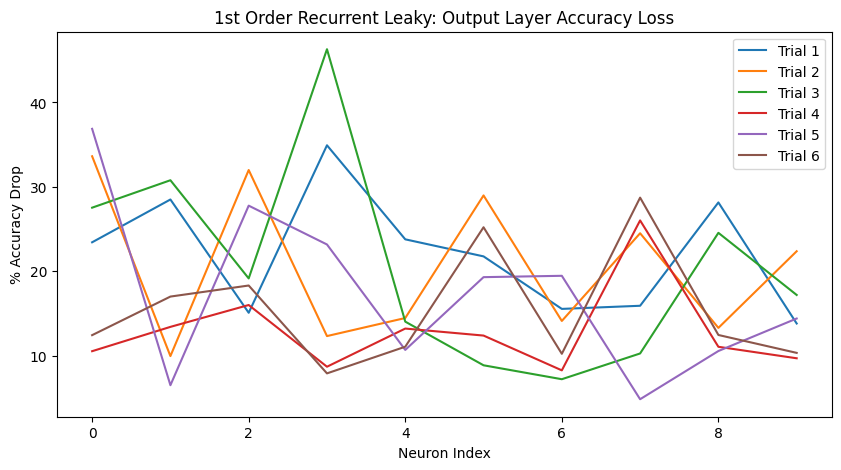

In [24]:
# Plot Accuracy Dop
fig = plt.figure(facecolor="w", figsize=(10, 5))
plt.plot(fc2_acc_loss_rec)
plt.plot(fc2_acc_loss_rec_2)
plt.plot(fc2_acc_loss_rec_3)
plt.plot(fc2_acc_loss_rec_4)
plt.plot(fc2_acc_loss_rec_5)
plt.plot(fc2_acc_loss_rec_6)
plt.title("1st Order Recurrent Leaky: Output Layer Accuracy Loss")
plt.legend(["Trial 1", "Trial 2","Trial 3","Trial 4","Trial 5","Trial 6",])
plt.xlabel("Neuron Index")
plt.ylabel("% Accuracy Drop")
plt.show()

In [25]:
# Multi-trial Hidden Layer Corruption

print("Starting Hidden Layer Trial 2")
fc1_acc_loss_rec_2 = []

test_net = Net()
test_net.load_state_dict(torch.load('ref_snn_rleaky.pth'))
test_net.to(device)

acc_ref = acc_test(test_net, mnist_test, batch_size)
# print(f"Base Accuracy: {(acc_ref):.2f}%")
for x in range(0,1000):
    with torch.no_grad():
        test_net = Net()
        test_net.load_state_dict(torch.load('ref_snn_rleaky.pth'))
        test_net.to(device)
        acc = acc_test(mod_fc1(test_net, x), mnist_test, batch_size)
        # print(f"Accuracy loss of Output Layer Parameter Corruption({x}): {(acc_ref-acc):.2f}%")
        fc1_acc_loss_rec_2.append(acc_ref-acc)
    del test_net
    torch.cuda.empty_cache()

print("Starting Hidden Layer Trial 3")
fc1_acc_loss_rec_3 = []

with torch.no_grad():
    test_net = Net()
    test_net.load_state_dict(torch.load('ref_snn_rleaky.pth'))
    test_net.to(device)

acc_ref = acc_test(test_net, mnist_test, batch_size)
# print(f"Base Accuracy: {(acc_ref):.2f}%")
for x in range(0,1000):
    with torch.no_grad():
        test_net = Net()
        test_net.load_state_dict(torch.load('ref_snn_rleaky.pth'))
        test_net.to(device)
        acc = acc_test(mod_fc1(test_net, x), mnist_test, batch_size)
        # print(f"Accuracy loss of Output Layer Parameter Corruption({x}): {(acc_ref-acc):.2f}%")
        fc1_acc_loss_rec_3.append(acc_ref-acc)
    del test_net
    torch.cuda.empty_cache()

print("Starting Hidden Layer Trial 4")
fc1_acc_loss_rec_4 = []

with torch.no_grad():
    test_net = Net()
    test_net.load_state_dict(torch.load('ref_snn_rleaky.pth'))
    test_net.to(device)

acc_ref = acc_test(test_net, mnist_test, batch_size)
# print(f"Base Accuracy: {(acc_ref):.2f}%")
for x in range(0,1000):
    with torch.no_grad():
        test_net = Net()
        test_net.load_state_dict(torch.load('ref_snn_rleaky.pth'))
        test_net.to(device)
        acc = acc_test(mod_fc1(test_net, x), mnist_test, batch_size)
        # print(f"Accuracy loss of Output Layer Parameter Corruption({x}): {(acc_ref-acc):.2f}%")
        fc1_acc_loss_rec_4.append(acc_ref-acc)
    del test_net
    torch.cuda.empty_cache()

print("Starting Hidden Layer Trial 5")
fc1_acc_loss_rec_5 = []

with torch.no_grad():
    test_net = Net()
    test_net.load_state_dict(torch.load('ref_snn_rleaky.pth'))
    test_net.to(device)

acc_ref = acc_test(test_net, mnist_test, batch_size)
# print(f"Base Accuracy: {(acc_ref):.2f}%")
for x in range(0,1000):
    with torch.no_grad():
        test_net = Net()
        test_net.load_state_dict(torch.load('ref_snn_rleaky.pth'))
        test_net.to(device)
        acc = acc_test(mod_fc1(test_net, x), mnist_test, batch_size)
        # print(f"Accuracy loss of Output Layer Parameter Corruption({x}): {(acc_ref-acc):.2f}%")
        fc1_acc_loss_rec_5.append(acc_ref-acc)
    del test_net
    torch.cuda.empty_cache()

print("Starting Hidden Layer Trial 6")
fc1_acc_loss_rec_6 = []

with torch.no_grad():
    test_net = Net()
    test_net.load_state_dict(torch.load('ref_snn_rleaky.pth'))
    test_net.to(device)

acc_ref = acc_test(test_net, mnist_test, batch_size)
# print(f"Base Accuracy: {(acc_ref):.2f}%")
for x in range(0,1000):
    with torch.no_grad():
        test_net = Net()
        test_net.load_state_dict(torch.load('ref_snn_rleaky.pth'))
        test_net.to(device)
        acc = acc_test(mod_fc1(test_net, x), mnist_test, batch_size)
        # print(f"Accuracy loss of Output Layer Parameter Corruption({x}): {(acc_ref-acc):.2f}%")
        fc1_acc_loss_rec_6.append(acc_ref-acc)
    del test_net
    torch.cuda.empty_cache()

Starting Hidden Layer Trial 2
Starting Hidden Layer Trial 3
Starting Hidden Layer Trial 4
Starting Hidden Layer Trial 5
Starting Hidden Layer Trial 6


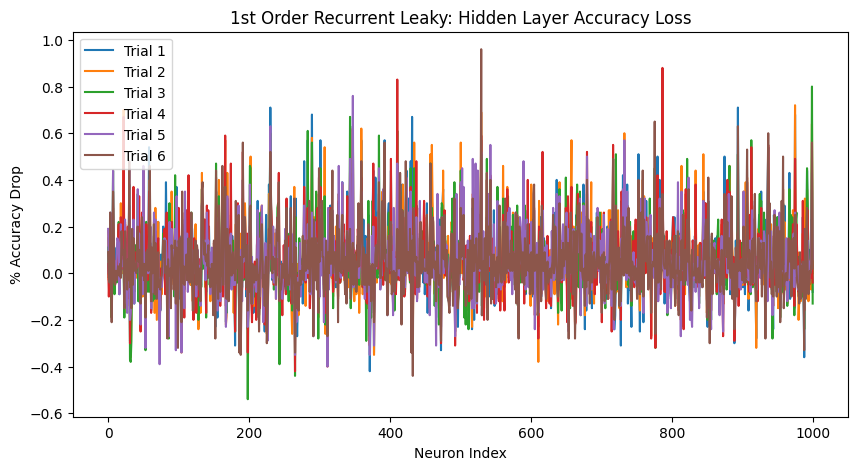

In [26]:
# Plot Accuracy Dop
fig = plt.figure(facecolor="w", figsize=(10, 5))
plt.plot(fc1_acc_loss_rec)
plt.plot(fc1_acc_loss_rec_2)
plt.plot(fc1_acc_loss_rec_3)
plt.plot(fc1_acc_loss_rec_4)
plt.plot(fc1_acc_loss_rec_5)
plt.plot(fc1_acc_loss_rec_6)
plt.title("1st Order Recurrent Leaky: Hidden Layer Accuracy Loss")
plt.legend(["Trial 1", "Trial 2","Trial 3","Trial 4","Trial 5","Trial 6",])
plt.xlabel("Neuron Index")
plt.ylabel("% Accuracy Drop")
plt.show()